In [1]:
# created: 2024/09/21
# Authors: Eva, Lily, Jennifer, Madeline

# Todo: Build up backtest program by 9/26/2024.

# 0. Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import yfinance as yf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

/Users/zhangli/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 1. Load and process data

Currently, the data csv files are stored in the colab environment.

If new data files are added, they must be uploaded again manually.

Because the google drive mount operation cannot mount to "Shared Folder", but only to "My Drive".

Putting functions ahead of operations can avoid future error warning.


In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# df_AMZN_v1 = pd.read_csv('gdrive/My Drive/AMZN_EPS.csv')
# df_BABA_v1 = pd.read_csv('gdrive/My Drive/BABA EPS.csv')
# df_WMT_v1 = pd.read_csv('gdrive/My Drive/WMT EPS.csv')

Mean estimate is the mean of all previous estimate until the estimate announcement date, and if one estimate announcement date has several estimates, we take the last mean

In [5]:
# def find_mean_estimate(df):

#   temp = df.copy()
#   temp['FPEDATS'] = pd.to_datetime(temp['FPEDATS'])
#   temp['ANNDATS_ACT'] = pd.to_datetime(temp['ANNDATS_ACT'])
#   temp['ANNDATS'] = pd.to_datetime(temp['ANNDATS'])

#   temp = temp.sort_values(by=['FPEDATS', 'ANNDATS'], ascending=[True, True])
#   temp['Mean_Est_EPS'] = temp.groupby('ANNDATS_ACT')['VALUE'].expanding().mean().reset_index(level=0, drop=True)

#   result = temp.groupby(['TICKER','FPEDATS','ANNDATS']).agg({
#       'Mean_Est_EPS':'last',
#       'ACTUAL': 'last',
#       'ANNDATS_ACT': 'last'
#       }).rename(columns={
#           'ACTUAL': 'EPS_ACT'
#       }).reset_index()

#   return result

In [6]:
def find_mean_estimate(df):
  temp = df.copy()
  temp['FPEDATS'] = pd.to_datetime(temp['FPEDATS'])
  temp['ANNDATS_ACT'] = pd.to_datetime(temp['ANNDATS_ACT'])
  temp['ANNDATS'] = pd.to_datetime(temp['ANNDATS'])

  # temp.dropna(subset=['VALUE', 'ACTUAL'], inplace=True)

  temp = temp.sort_values(by=['FPEDATS', 'ANNDATS'], ascending=[True, True])
  # temp = temp.sort_values(by=['ANNDATS'], ascending=[True, True])

  result = temp.groupby(['TICKER', 'FPEDATS', 'ANNDATS']).agg({
      'VALUE': 'mean',
      'ACTUAL': 'first',
      'ANNDATS_ACT': 'first'
      }).rename(columns={
          'VALUE': 'Mean_Est_REV',
          'ACTUAL': 'REV_ACT'
      })

  result = result.reset_index()
  return result

Since there might not be estimate eps data for a certain day difference before an announcement date, we chose the closest data.

In [7]:
def select_timeDiff(df, day_diff):

  temp = df.copy()
  temp['day_diff'] = (temp['ANNDATS_ACT'] - temp['ANNDATS']).dt.days

  mask = temp['day_diff'] >= day_diff
  result = temp[mask].copy()

  result['diff_from_target'] = result['day_diff'] - day_diff
  idx = result.groupby('ANNDATS_ACT')['diff_from_target'].idxmin()
  result = result.loc[idx]

  result = result.reset_index(drop=True)
  result = result.drop(['day_diff','diff_from_target'], axis=1)
  return result

buy/short signal for a certain stock & day difference

In [8]:
def beat_estimate(df):

  temp = df.copy()
  temp['beat_est'] = temp['REV_ACT'] >= temp['Mean_Est_REV']

  result = temp[['TICKER', 'ANNDATS','ANNDATS_ACT','Mean_Est_REV','REV_ACT','beat_est']]
  result = result.rename(columns={
      'TICKER': 'ticker',
      'ANNDATS': 'annDates_est',
      'ANNDATS_ACT': 'annDates_act',
      'Mean_Est_EPS': 'eps_est',
      'EPS_ACT': 'eps_act'
  })

  return result

Calculating returns based on holding period (since no values on non-business days, we trade on the closest future date, eg. if 10 days before annoucement date is saturday, we trade on monday)



In [9]:
def calc_returns (df, ticker, day_diff):

  result = df.copy()

  stock_price = yf.download(ticker, start='2019-07-01', end='2024-09-23')
  all_dates = pd.date_range(start='2019-07-01', end='2024-09-23')

  stock_price = stock_price.reindex(all_dates)['Close'].pct_change(periods=day_diff, fill_method='bfill')
  result = pd.merge(result, stock_price, left_on='annDates_act', right_index=True, how='left').rename(columns={'Close': 'returns'})
  # alternative (to show buy and sell prices):
  # stock_price = stock_price.reindex(all_dates).fillna(method='bfill')
  # stock_price["close_shift"] = stock_price["Close"].shift(day_diff)
  # stock_price["returns"] = (stock_price["Close"] - stock_price["close_shift"])/stock_price["close_shift"]
  # stock_price = stock_price[['Close', 'close_shift', 'returns']].rename(columns={'Close': 'close'})
  # result = pd.merge(df, stock_price, left_on='annDates_act', right_index=True, how='left')

  return result

In [10]:
# df1 = avg_eps(df)
# df2 = time_diff(df1)
# df3 = select_timeDiff(df2,10)
# df4 = beat_estimate(df3)

In [11]:
# df4.head()

In [57]:
# 这里报错是正常的，需要重新上传data
# Todo 之后改成通过git 读取数据

# df_AMZN_v1 = pd.read_csv('AMZN EPS.csv')
# df_BABA_v1 = pd.read_csv('BABA EPS.csv')
# df_WMT_v1 = pd.read_csv('WMT EPS.csv')

df_AMZN_v1 = pd.read_csv('AMZN REV.csv')
df_BABA_v1 = pd.read_csv('BABA REV.csv')
df_WMT_v1 = pd.read_csv('WMT REV.csv')

final dataframes with:
- annDates_est: estimate annoucement date (datetime)
- annDates_act: actual annoucement date (datetime)
- eps_est: eps estimate value (float)
- eps_act: eps actual value (float)
- beat_est: is actual > estimate (bool)
- returns: the cumulative return of the holding period (float)

In [58]:
holding_period = 20
df_AMZN = (df_AMZN_v1
          .pipe(find_mean_estimate)
          .pipe(select_timeDiff, day_diff=holding_period)
          .pipe(beat_estimate)
          .pipe(calc_returns, ticker='AMZN', day_diff=holding_period))
df_BABA = (df_BABA_v1
          .pipe(find_mean_estimate)
          .pipe(select_timeDiff, day_diff=holding_period)
          .pipe(beat_estimate)
          .pipe(calc_returns, ticker='BABA', day_diff=holding_period))
df_WMT = (df_WMT_v1
          .pipe(find_mean_estimate)
          .pipe(select_timeDiff, day_diff=holding_period)
          .pipe(beat_estimate)
          .pipe(calc_returns, ticker='WMT', day_diff=holding_period))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [59]:
df_AMZN.head()

,ticker,annDates_est,annDates_act,Mean_Est_REV,REV_ACT,beat_est,returns
0,AMZN,2019-09-18,2019-10-24,"69,656.500","69,981.000",True,0.024
1,AMZN,2020-01-09,2020-01-30,"182,326.500","280,522.000",True,-0.007
2,AMZN,2020-04-08,2020-04-30,"75,699.000","75,452.000",False,0.141
3,AMZN,2020-07-09,2020-07-30,"80,679.133","88,912.000",True,-0.046
4,AMZN,2020-10-07,2020-10-29,"93,225.000","96,145.000",True,-0.023


In [60]:
df_BABA.head()

,ticker,annDates_est,annDates_act,Mean_Est_REV,REV_ACT,beat_est,returns
0,BABA,2019-10-09,2019-11-01,"115,972.000","119,017.000",True,0.031
1,BABA,2020-01-21,2020-02-13,"161,415.560","161,456.000",True,0.031
2,BABA,2020-04-29,2020-05-22,"367,571.667","509,711.000",True,0.045
3,BABA,2020-07-25,2020-08-20,"148,565.000","153,751.000",True,0.028
4,BABA,2020-10-15,2020-11-05,"153,383.000","155,059.000",True,-0.064


In [61]:
df_WMT.head()

,ticker,annDates_est,annDates_act,Mean_Est_REV,REV_ACT,beat_est,returns
0,WMT,2019-10-23,2019-11-14,"129,981.000","127,991.000",False,0.014
1,WMT,2020-01-21,2020-02-18,"529,346.900","523,964.000",False,0.032
2,WMT,2020-04-28,2020-05-19,"125,491.000","134,622.000",True,0.011
3,WMT,2020-07-29,2020-08-18,"139,430.000","137,742.000",False,0.031
4,WMT,2020-10-15,2020-11-17,"134,896.000","134,708.000",False,0.067


# 2. Strategy functions

Set thresholds and actions for different strategies. Below input and output parameters are subject to future changes.

Default input parameters (example):

*   stock_i
*   today_date
*   data


Default output (example):

*   gain/loss


applies strategy by multiplying the returns by 1, if beat to long, and by -1, if miss to short
then, find the quarterly cumulative returns

In [62]:
def strat (df):

  df['strat_returns'] = np.where(df['beat_est'], df['returns']*1, df['returns']*-1)
  df['cum_strat_returns'] = (1+df['strat_returns']).cumprod()-1

  print("Cumulative Return:", round(df['cum_strat_returns'].iloc[-1],3))

  return df

In [63]:
def portfolio (list_df):

  temp = list_df[0].copy()
  temp = temp.rename(columns={'strat_returns': f"{temp['ticker'].dropna().iloc[0]}_strat_returns_p"})

  for df in list_df[1:]:
    temp = pd.merge(temp, df, on='annDates_act', how='outer')
    temp = temp.rename(columns={'strat_returns': f"{df['ticker'].dropna().iloc[0]}_strat_returns_p"})

  filter = temp.filter(regex='_strat_returns_p$').columns.tolist()
  temp = temp[['annDates_act']+filter]

  temp['strat_returns'] = temp.filter(regex='_strat_returns_p$').sum(axis=1)
  temp = temp.sort_values(by='annDates_act').reset_index(drop=True)

  temp['cum_strat_returns'] = temp['strat_returns'].cumsum()

  print("Cumulative Return:", temp['strat_returns'].sum())

  return temp

# 3. Backtest

Apply strategy functions and record daily PnL & Cum_PnL

In [64]:
df_AMZN = strat(df_AMZN)
df_AMZN.head()

Cumulative Return: 0.011


,ticker,annDates_est,annDates_act,Mean_Est_REV,REV_ACT,beat_est,returns,strat_returns,cum_strat_returns
0,AMZN,2019-09-18,2019-10-24,"69,656.500","69,981.000",True,0.024,0.024,0.024
1,AMZN,2020-01-09,2020-01-30,"182,326.500","280,522.000",True,-0.007,-0.007,0.017
2,AMZN,2020-04-08,2020-04-30,"75,699.000","75,452.000",False,0.141,-0.141,-0.126
3,AMZN,2020-07-09,2020-07-30,"80,679.133","88,912.000",True,-0.046,-0.046,-0.167
4,AMZN,2020-10-07,2020-10-29,"93,225.000","96,145.000",True,-0.023,-0.023,-0.186


In [65]:
df_BABA = strat(df_BABA)
df_BABA.head()

Cumulative Return: 0.37


,ticker,annDates_est,annDates_act,Mean_Est_REV,REV_ACT,beat_est,returns,strat_returns,cum_strat_returns
0,BABA,2019-10-09,2019-11-01,"115,972.000","119,017.000",True,0.031,0.031,0.031
1,BABA,2020-01-21,2020-02-13,"161,415.560","161,456.000",True,0.031,0.031,0.063
2,BABA,2020-04-29,2020-05-22,"367,571.667","509,711.000",True,0.045,0.045,0.110
3,BABA,2020-07-25,2020-08-20,"148,565.000","153,751.000",True,0.028,0.028,0.141
4,BABA,2020-10-15,2020-11-05,"153,383.000","155,059.000",True,-0.064,-0.064,0.068


In [66]:
df_WMT = strat(df_WMT)
df_WMT.head()

Cumulative Return: 0.383


,ticker,annDates_est,annDates_act,Mean_Est_REV,REV_ACT,beat_est,returns,strat_returns,cum_strat_returns
0,WMT,2019-10-23,2019-11-14,"129,981.000","127,991.000",False,0.014,-0.014,-0.014
1,WMT,2020-01-21,2020-02-18,"529,346.900","523,964.000",False,0.032,-0.032,-0.045
2,WMT,2020-04-28,2020-05-19,"125,491.000","134,622.000",True,0.011,0.011,-0.035
3,WMT,2020-07-29,2020-08-18,"139,430.000","137,742.000",False,0.031,-0.031,-0.065
4,WMT,2020-10-15,2020-11-17,"134,896.000","134,708.000",False,0.067,-0.067,-0.127


In [67]:
dfs = [df_AMZN, df_BABA, df_WMT]
df_port = portfolio(dfs)
df_port.head()

Cumulative Return: 0.823284452152534


,annDates_act,AMZN_strat_returns_p,BABA_strat_returns_p,WMT_strat_returns_p,strat_returns,cum_strat_returns
0,2019-10-24,0.024,NaN,NaN,0.024,0.024
1,2019-11-01,NaN,0.031,NaN,0.031,0.055
2,2019-11-14,NaN,NaN,-0.014,-0.014,0.041
3,2020-01-30,-0.007,NaN,NaN,-0.007,0.034
4,2020-02-13,NaN,0.031,NaN,0.031,0.065


# 4. Plot results and analysis

Plot the daily PnL and Cum_PnL.

Summarize maximum drawdown and return rate.

Analyze why the results occur.

In [68]:
def plot (df, ticker):
  plt.figure()
  plt.plot(df['annDates_act'], df["strat_returns"], marker='o', label='Quarterly Returns')
  plt.plot(df['annDates_act'], df["cum_strat_returns"], marker='o', label='Cumulative Returns')
  plt.title(ticker + ' Quarterly Returns vs Cumulative Returns')
  plt.axhline(0, linestyle='--', color='red')
  plt.xlabel('Quarters')
  plt.ylabel('Returns')
  plt.legend()
  plt.show()

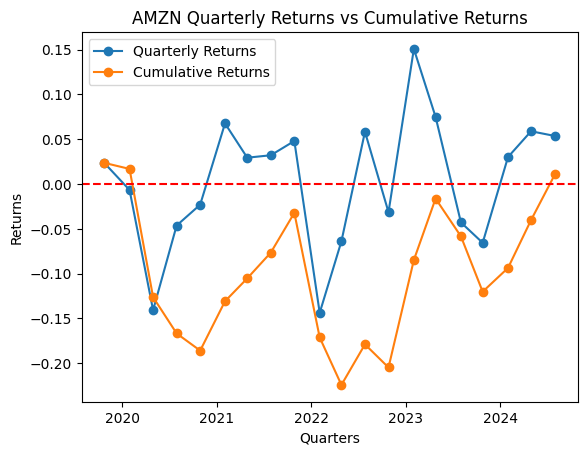

In [69]:
plot(df_AMZN, 'AMZN')

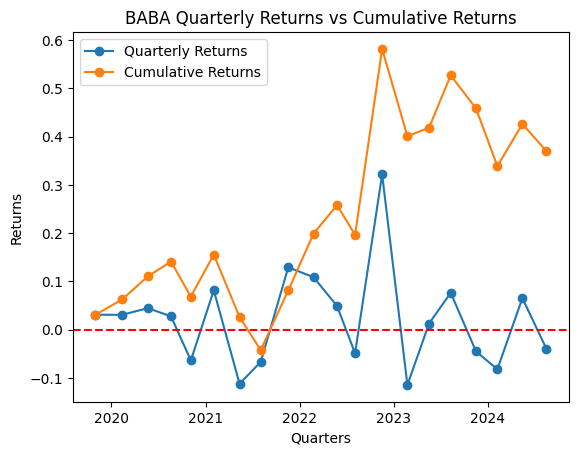

In [70]:
plot(df_BABA, 'BABA')

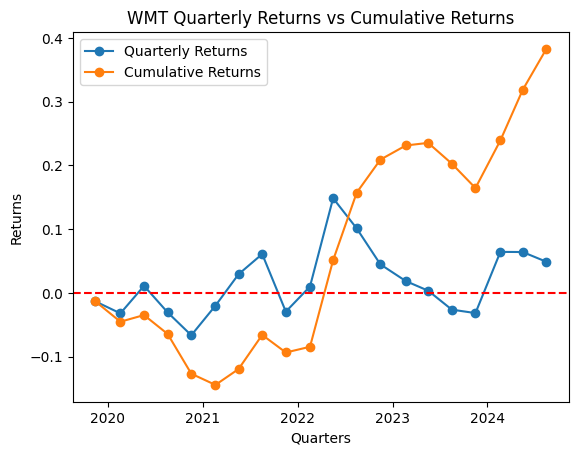

In [71]:
plot(df_WMT, 'WMT')

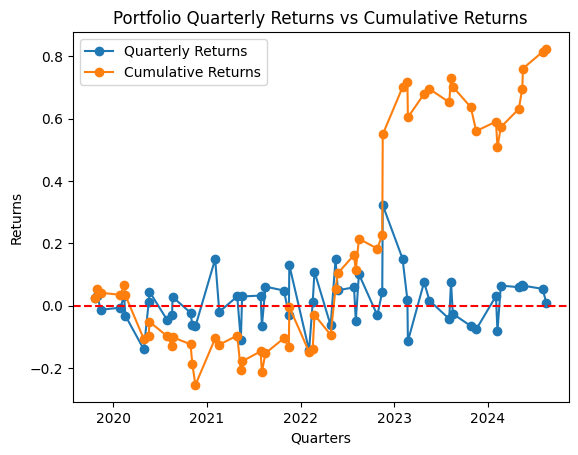

In [72]:
plot(df_port, "Portfolio")